In [2]:
import numpy as np
import xarray as xr

In [3]:
# --- Load tvt mask once ---
tvt = xr.open_dataarray("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/masks/tvt_mask.nc")

# Boolean mask for test points
test_mask = (tvt == 2)

# If tvt has a time dimension but the mask is constant in time,
# just take one time slice to avoid carrying time everywhere.
if "time" in test_mask.dims:
    test_mask = test_mask.isel(time=0)

def open_masked(path, mask=test_mask):
    """Open a DataArray and apply the test mask."""
    da = xr.open_dataarray(path)
    return da.where(mask)

   

# ---------- ENSMEAN ----------
ens = {
    "lai":     open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/ensmean/S3/ENSMEAN_S3_lai.nc"),
    "cVeg":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/ensmean/S3/ENSMEAN_S3_cVeg.nc"),
    "cLitter": open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/ensmean/S3/ENSMEAN_S3_cLitter.nc"),
    "cSoil":   open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/ensmean/S3/ENSMEAN_S3_cSoil.nc"),
    "mrso":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/ensmean/S3/ENSMEAN_S3_mrso.nc"),
}

# ---------- Base teacher ----------
base = {
    "lai":     open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/lai/ENSMEAN/ENSMEAN_S3_lai.nc"),
    "cVeg":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cVeg/ENSMEAN/ENSMEAN_S3_cVeg.nc"),
    "cLitter": open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cLitter/ENSMEAN/ENSMEAN_S3_cLitter.nc"),
    "cSoil":   open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/cSoil/ENSMEAN/ENSMEAN_S3_cSoil.nc"),
    "mrso":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/base_vs_ensmean_scenarios/S3/DATA/mrso/ENSMEAN/ENSMEAN_S3_mrso.nc"),
}

# ---------- Base carry ----------
base_carry = {
    "lai":     open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/lai.nc"),
    "cVeg":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cVeg.nc"),
    "cLitter": open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cLitter.nc"),
    "cSoil":   open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/cSoil.nc"),
    "mrso":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/pipeline/3.benchmark/ilamb/old/carry_distances/MODELS/base_model/S3/mrso.nc"),
}

# ---------- Stable carry ----------
stable_carry = {
    "lai":     open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/stable/carry/S3/lai.nc"),
    "cVeg":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/stable/carry/S3/cVeg.nc"),
    "cLitter": open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/stable/carry/S3/cLitter.nc"),
    "cSoil":   open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/stable/carry/S3/cSoil.nc"),
    "mrso":    open_masked(f"/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preds_for_analysis/stable/carry/S3/mrso.nc"),
}

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr


def _flatten_obs_model(
    da_obs,
    da_mod,
    subset_size=None,
    random_state=None,
):
    """
    Align obs & model, flatten (time, lat, lon) -> 1D and optionally subsample.
    Returns x, y, years arrays (np.ndarray).
    """
    # Align on all dims (time, lat, lon)
    da_obs, da_mod = xr.align(da_obs, da_mod, join="inner")

    # Stack to 1D
    da_obs_st = da_obs.stack(points=("time", "lat", "lon"))
    da_mod_st = da_mod.stack(points=("time", "lat", "lon"))

    # Extract time coordinate per point
    time_coord = da_obs_st["time"]

    x = da_obs_st.values
    y = da_mod_st.values
    years = time_coord.dt.year.values

    # Mask out NaNs in either
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    years = years[mask]

    # Optional subsampling
    n = x.shape[0]
    if (subset_size is not None) and (subset_size > 0) and (subset_size < n):
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n, size=subset_size, replace=False)
        x = x[idx]
        y = y[idx]
        years = years[idx]

    return x, y, years


def _compute_density_alpha(
    x,
    y,
    min_alpha=0.05,
    max_alpha=0.9,
    bins=100,
):
    """
    Estimate 2D density via histogram and map to per-point alpha.
    Higher local density -> higher alpha (more opaque).
    """
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Bin index for each point
    x_bin = np.searchsorted(xedges, x, side="right") - 1
    y_bin = np.searchsorted(yedges, y, side="right") - 1

    valid = (
        (x_bin >= 0) & (x_bin < H.shape[0]) &
        (y_bin >= 0) & (y_bin < H.shape[1])
    )

    density = np.zeros_like(x, dtype=float)
    density[valid] = H[x_bin[valid], y_bin[valid]]

    dens_nonzero = density[density > 0]
    if dens_nonzero.size == 0:
        return np.full_like(x, max_alpha, dtype=float)

    dens_min = dens_nonzero.min()
    dens_max = dens_nonzero.max()

    dens_norm = np.zeros_like(density, dtype=float)
    if dens_max > dens_min:
        dens_norm = (density - dens_min) / (dens_max - dens_min)
        dens_norm[density == 0] = 0.0

    alphas = min_alpha + dens_norm * (max_alpha - min_alpha)
    return alphas


def plot_r2_panel(
    ens_dict,
    base_carry_dict,
    stable_carry_dict,
    vars_order=None,
    color_by_year=False,
    density_alpha=False,
    subset_size=None,
    marker_size=3,
    min_alpha=0.05,
    max_alpha=0.9,
    cmap="viridis",
    random_state=None,
    outfile=None,
):
    """
    Plot a 5x2 panel of obs vs model scatterplots with R² annotations.

    Left column  : Base with carry  (y-axis)
    Right column : Stable with carry (y-axis)
    X-axis       : TEM (ENSMEAN; 'ens' dict) = observation

    Rows (fixed order by default):
      1: cVeg
      2: cLitter
      3: cSoil
      4: mrso
      5: lai

    If color_by_year=True, points are coloured by year with a shared colourbar.
    Each subplot uses its own x/y range and labels include units inferred from
    the underlying DataArrays.
    """
    if vars_order is None:
        vars_order = ["cVeg", "cLitter", "cSoil", "mrso", "lai"]

    # Pretty labels
    pretty_names = {
        "cVeg": "cVeg",
        "cLitter": "cLitter",
        "cSoil": "cSoil",
        "mrso": "MRSO",
        "lai": "LAI",
    }

    n_rows = len(vars_order)
    n_cols = 2

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(8, 12),
        sharex=False,   # each plot gets its own x-range
        sharey=False,   # and its own y-range
    )
    axes = np.atleast_2d(axes)

    # Column titles
    axes[0, 0].set_title("Base-Emulator (Carry)", fontsize=12, fontweight="bold")
    axes[0, 1].set_title("Stable-Emulator (Carry)", fontsize=12, fontweight="bold")

    # Prepare colormap
    cmap_obj = plt.get_cmap(cmap)
    year_norm = None
    year_min_global = None
    year_max_global = None

    # Decode obs once per variable + build global year range if needed
    obs_decoded = {}
    if color_by_year:
        all_year_mins = []
        all_year_maxs = []

    for var in vars_order:
        if var not in ens_dict:
            continue
        da_obs = ens_dict[var]

        # Decode CF time if needed (handles cftime/no-leap)
        if not np.issubdtype(da_obs["time"].dtype, np.datetime64):
            da_obs = xr.decode_cf(da_obs.to_dataset(name="tmp"))["tmp"]

        obs_decoded[var] = da_obs

        if color_by_year:
            years_all = da_obs["time"].dt.year.values
            if years_all.size > 0:
                all_year_mins.append(years_all.min())
                all_year_maxs.append(years_all.max())

    if color_by_year and all_year_mins:
        year_min_global = int(np.min(all_year_mins))
        year_max_global = int(np.max(all_year_maxs))
        if year_max_global > year_min_global:
            year_norm = matplotlib.colors.Normalize(
                vmin=year_min_global,
                vmax=year_max_global,
            )
        else:
            # fallback if only a single year
            year_norm = matplotlib.colors.Normalize(
                vmin=year_min_global - 0.5,
                vmax=year_max_global + 0.5,
            )
    elif color_by_year:
        # No usable years; disable year colouring
        color_by_year = False

    for row, var in enumerate(vars_order):
        if var not in obs_decoded or var not in base_carry_dict or var not in stable_carry_dict:
            # Skip missing vars gracefully
            for col in range(n_cols):
                ax = axes[row, col]
                ax.text(
                    0.5,
                    0.5,
                    "Missing data",
                    transform=ax.transAxes,
                    ha="center",
                    va="center",
                )
                ax.set_axis_off()
            continue

        da_obs = obs_decoded[var]
        obs_units = da_obs.attrs.get("units", "")

        for col, (model_dict, col_label) in enumerate(
            [(base_carry_dict, "Base"), (stable_carry_dict, "Stable")]
        ):
            ax = axes[row, col]
            da_mod = model_dict[var]
            mod_units = da_mod.attrs.get("units", "")

            # Align & flatten
            x, y, years = _flatten_obs_model(
                da_obs,
                da_mod,
                subset_size=subset_size,
                random_state=random_state,
            )

            if x.size == 0:
                ax.text(
                    0.5,
                    0.5,
                    "No data",
                    transform=ax.transAxes,
                    ha="center",
                    va="center",
                )
                ax.set_axis_off()
                continue

            # Per-panel 1:1 limits
            xy_min = np.nanmin([x.min(), y.min()])
            xy_max = np.nanmax([x.max(), y.max()])
            pad = 0.02 * (xy_max - xy_min) if xy_max > xy_min else 1.0
            xy_min -= pad
            xy_max += pad

            # Density-based alpha
            if density_alpha:
                alphas = _compute_density_alpha(
                    x, y, min_alpha=min_alpha, max_alpha=max_alpha
                )
            else:
                alphas = np.full_like(x, max_alpha, dtype=float)

            # Colours
            if color_by_year and (year_norm is not None):
                colors = cmap_obj(year_norm(years))
                # Inject per-point alpha
                colors = np.array(colors)
                colors[:, 3] = alphas
                ax.scatter(x, y, s=marker_size, c=colors, marker=".", linewidths=0)
            else:
                # Solid blue with per-point alpha
                base_color = np.array(matplotlib.colors.to_rgba("C0"))
                colors = np.tile(base_color, (x.size, 1))
                colors[:, 3] = alphas
                ax.scatter(x, y, s=marker_size, c=colors, marker=".", linewidths=0)

            # 1:1 line
            ax.plot(
                [xy_min, xy_max],
                [xy_min, xy_max],
                color="0.4",
                linestyle="--",
                linewidth=1.0,
                zorder=1,
            )

            ax.set_xlim(xy_min, xy_max)
            ax.set_ylim(xy_min, xy_max)

            # R^2
            r = np.corrcoef(x, y)[0, 1]
            r2 = r ** 2
            ax.text(
                0.04,
                0.96,
                f"$R^2 = {r2:.2f}$",
                transform=ax.transAxes,
                ha="left",
                va="top",
                fontsize=9,
                bbox=dict(
                    boxstyle="round,pad=0.2",
                    facecolor="white",
                    edgecolor="0.8",
                    alpha=0.8,
                ),
            )

            # Y label only on left column, include units from model
            if col == 0:
                label = pretty_names.get(var, var)
                if mod_units:
                    label = f"{label} [{mod_units}]"
                ax.set_ylabel(label, fontsize=11)

            # X labels only on bottom row, include units from obs
            if row == n_rows - 1:
                xlabel = "TEM (ENSMEAN)"
                if obs_units:
                    xlabel = f"{xlabel} [{obs_units}]"
                ax.set_xlabel(xlabel, fontsize=11)

            # Clean aesthetics
            ax.grid(True, alpha=0.2)
            for spine in ("top", "right"):
                ax.spines[spine].set_visible(False)

    # Layout + colourbar for years
    # Leave room on the right for the colourbar
    plt.tight_layout(rect=[0.0, 0.0, 0.93, 1.0])

    if color_by_year and (year_norm is not None):
        # Shared colourbar for years on the right
        sm = plt.cm.ScalarMappable(cmap=cmap_obj, norm=year_norm)
        sm.set_array([])
        cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label("Year", fontsize=11)

    if outfile is not None:
        fig.savefig(outfile, dpi=300, bbox_inches="tight")
        print(f"[INFO] Saved R² panel to {outfile}")
    else:
        plt.show()

    plt.close(fig)

In [ ]:
plot_r2_panel(
    ens_dict=ens,
    base_carry_dict=base_carry,
    stable_carry_dict=stable_carry,
    color_by_year=True,       # colour scale by year
    density_alpha=True,       # density-based alpha
    subset_size=100000,       # random subset of points (time × space)
    marker_size=5,
    min_alpha=0.05,
    max_alpha=1,
    cmap="cividis",
    random_state=42,
    outfile="r2_panel_S3_states.png",
)

NameError: name 'plot_r2_panel' is not defined

In [ ]:
plot_r2_panel(
    ens_dict=ens,
    base_carry_dict=base_carry,
    stable_carry_dict=stable_carry,
    color_by_year=False,       # colour scale by year
    density_alpha=True,       # density-based alpha
    subset_size=100000,       # random subset of points (time × space)
    marker_size=5,
    min_alpha=0.05,
    max_alpha=1,
    cmap="cividis",
    random_state=42,
    outfile="r2_panel_S3_states_no_year.png",
)

NameError: name 'plot_r2_panel' is not defined

In [ ]:
plot_r2_panel(
    ens, base_carry, stable_carry,
    color_by_year=False,
    density_alpha=False,
    subset_size=50000,
    marker_size=2,
    outfile="r2_panel_S3_states_nodensity.png",
)

[INFO] Saved R² panel to r2_panel_S3_states_nodensity.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def scatter(
    x, y,
    time=None,
    title="",
    xlabel="",
    ylabel="",
    point_size=10,
    xmin=None, xmax=None,
    ymin=None, ymax=None,
    density_=1.0,
    bins=100,
    cmap_min_year=1901,
    cmap_max_year=2023,
    max_points=200_000,     # <<< NEW
):
    """
    Fast scatter plot with:
      - density-based transparency
      - optional time-based colouring
      - optional subsampling (max_points)
    """
    # --- Convert to numpy ---
    x = np.asarray(x)
    y = np.asarray(y)

    # --- Broadcast x, y, time ---
    if time is not None:
        time = np.asarray(time)
        x, y, time = np.broadcast_arrays(x, y, time)

        if (np.issubdtype(time.dtype, np.number) or
            np.issubdtype(time.dtype, np.datetime64)):
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(time)
        else:
            mask = np.isfinite(x) & np.isfinite(y)
    else:
        x, y = np.broadcast_arrays(x, y)
        mask = np.isfinite(x) & np.isfinite(y)

    # --- Apply mask ---
    x = x[mask]
    y = y[mask]
    if time is not None:
        time = time[mask]

    # --- Subsample (NEW) ---
    N = x.size
    if max_points is not None and N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)
        x = x[idx]
        y = y[idx]
        if time is not None:
            time = time[idx]

    if x.size == 0:
        raise ValueError("No valid points to plot after masking/subsampling.")

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    # --- Determine axis limits ---
    x_min = x.min() if xmin is None else xmin
    x_max = x.max() if xmax is None else xmax
    y_min = y.min() if ymin is None else ymin
    y_max = y.max() if ymax is None else ymax

    # Avoid zero-width extent
    if x_min == x_max:
        x_min -= 0.5; x_max += 0.5
    if y_min == y_max:
        y_min -= 0.5; y_max += 0.5

    # --- Compute 2D histogram ---
    H, xedges, yedges = np.histogram2d(
        x, y, bins=bins,
        range=[[x_min, x_max], [y_min, y_max]]
    )

    # Map each point to bin index
    x_idx = np.searchsorted(xedges, x, side="right") - 1
    y_idx = np.searchsorted(yedges, y, side="right") - 1
    x_idx = np.clip(x_idx, 0, bins - 1)
    y_idx = np.clip(y_idx, 0, bins - 1)

    density = H[x_idx, y_idx].astype(float)
    density_norm = (density - density.min()) / (density.max() - density.min() + 1e-9)
    density_scaled = density_norm ** (1 / max(density_, 1e-9))
    alpha = 0.05 + 0.7 * density_scaled

    # --- Convert time to year for colouring ---
    scatter_kwargs = dict(s=point_size, alpha=alpha)

    if time is not None:
        # datetime64
        if np.issubdtype(time.dtype, np.datetime64):
            years = time.astype("datetime64[Y]").astype(int) + 1970

        elif np.issubdtype(time.dtype, np.number):
            tmin, tmax = np.nanmin(time), np.nanmax(time)
            if 1800 <= tmin <= 3000:
                years = time
            else:
                years = 1901 + (time.astype(float) // 365).astype(int)

        else:
            years = np.array([getattr(t, "year", np.nan) for t in time])
            good = np.isfinite(years)
            x, y, alpha, years = x[good], y[good], alpha[good], years[good]

        norm = plt.Normalize(cmap_min_year, cmap_max_year)
        sc = ax.scatter(x, y, c=years, cmap="cividis", norm=norm, **scatter_kwargs)
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label("Year")
    else:
        ax.scatter(x, y, color="blue", **scatter_kwargs)

    # --- 1:1 line ---
    lim_min = min(x_min, y_min)
    lim_max = max(x_max, y_max)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], "--", color="red", linewidth=1)

    # --- Axis limits ---
    ax.set_xlim(x_min if xmin is None else xmin, x_max if xmax is None else xmax)
    ax.set_ylim(y_min if ymin is None else ymin, y_max if ymax is None else ymax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    return fig, ax

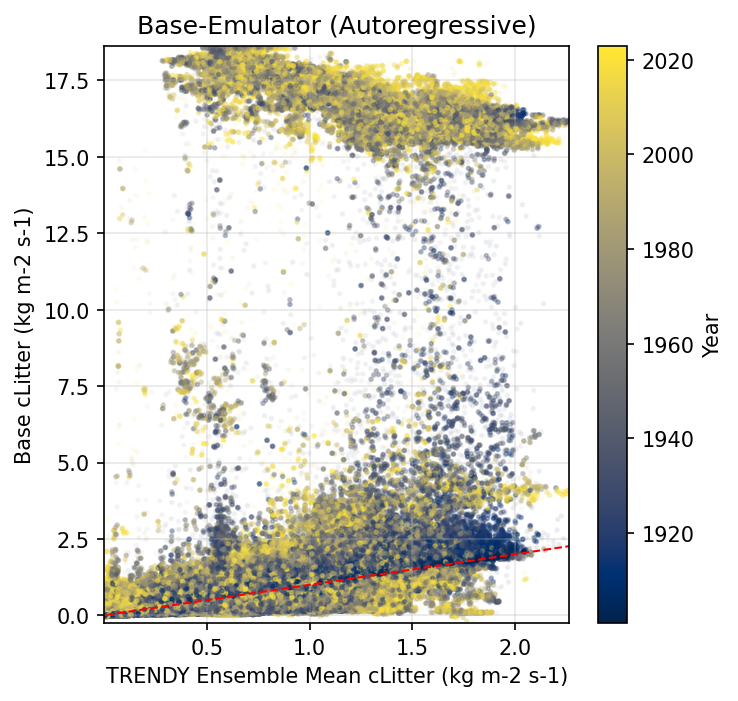

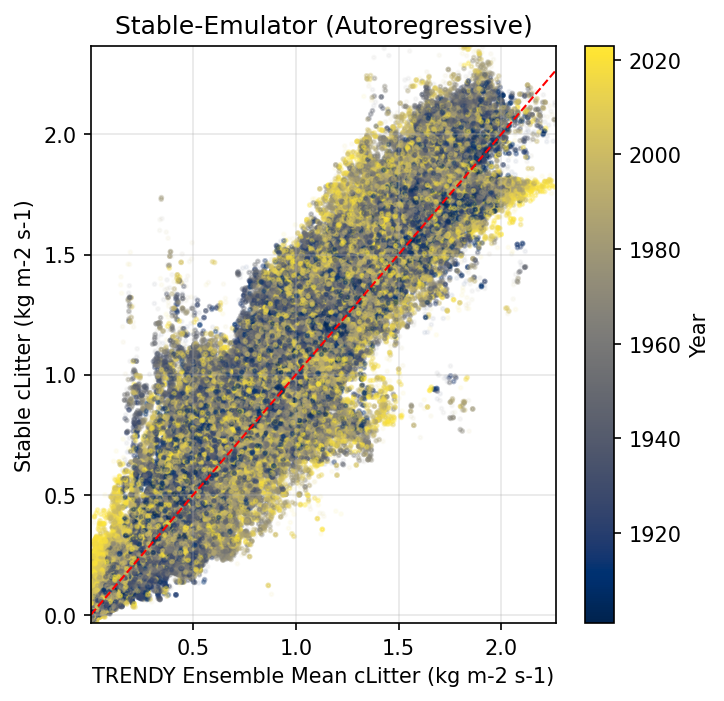

In [ ]:
# Base
da_ens = ens['cLitter']         # masked ENS
da_model = base_carry['cLitter']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Base-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cLitter (kg m-2 s-1)",
    ylabel="Base cLitter (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)
# Stable
da_ens = ens['cLitter']         # masked ENS
da_model = stable_carry['cLitter']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Stable-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cLitter (kg m-2 s-1)",
    ylabel="Stable cLitter (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)

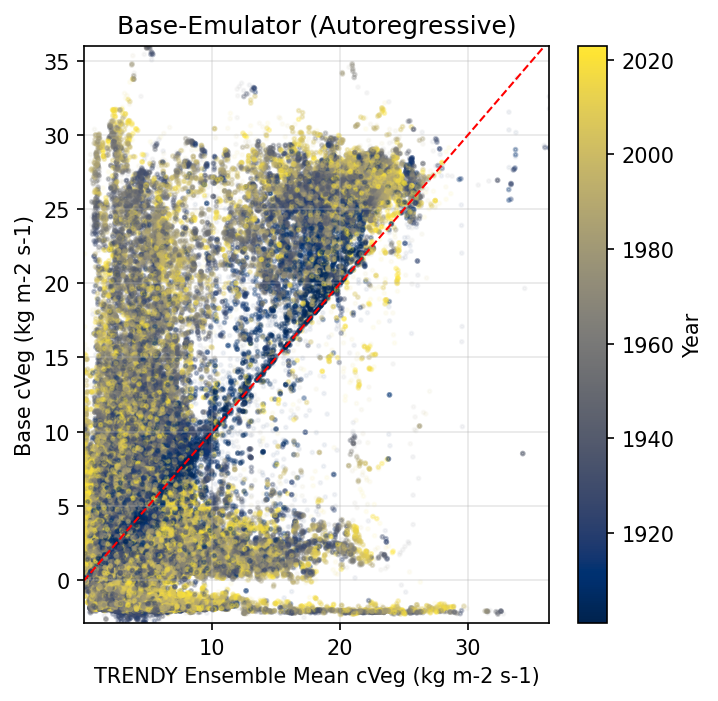

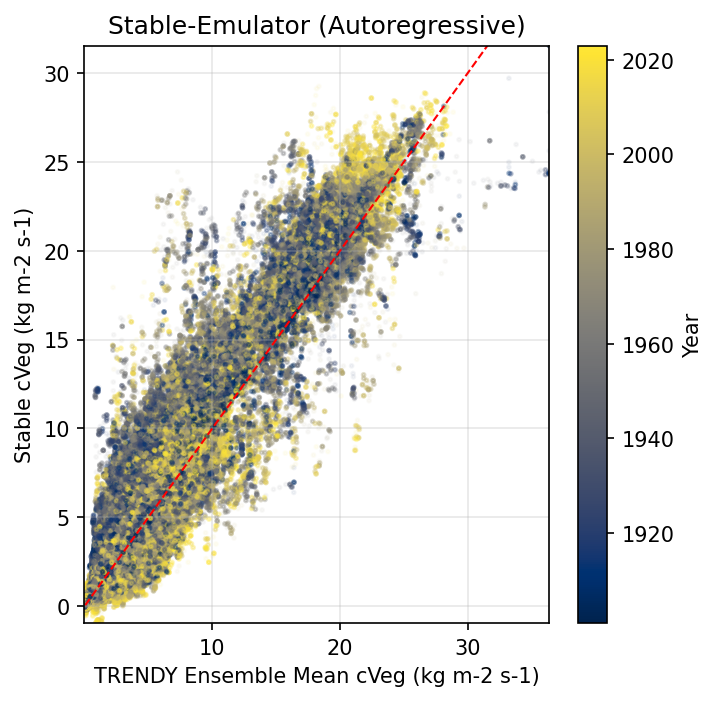

In [ ]:
# Base
da_ens = ens['cVeg']         # masked ENS
da_model = base_carry['cVeg']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Base-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cVeg (kg m-2 s-1)",
    ylabel="Base cVeg (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)
# Stable
da_ens = ens['cVeg']         # masked ENS
da_model = stable_carry['cVeg']

time_days = da_ens['time'].values      # cftime.DatetimeNoLeap
time_3d = time_days[:, None, None]     # (time, 1, 1) → broadcasts

fig, ax = scatter(
    da_ens.values,
    da_model.values,
    time=time_3d,
    title="Stable-Emulator (Autoregressive)",
    xlabel="TRENDY Ensemble Mean cVeg (kg m-2 s-1)",
    ylabel="Stable cVeg (kg m-2 s-1)",
    point_size=3,
    density_=10,
    max_points=200_000,
)